Data Pre-Processing and Preparing

In [6]:
import os

import pandas as pd

from data_preprocessing import xml_to_df
from data_preparing import split_data


max_size = 50 # small number just to reduce computation time for saving
xml_files = []
data_path = "../data-querying/results/"
folder_names = ["human_medical_data/", "veterinary_medical_data/"]
for folder in folder_names:
    xml_files.append([f"{data_path}{folder}{xml}" for xml in os.listdir(data_path + folder)])

hum_df, vet_df = xml_to_df(xml_files)

# balance case reports and other text types
vet_case_rep = vet_df[vet_df['text_types'].apply(lambda x: "Case Reports" in x)].sample(frac=1, random_state=42).reset_index(drop=True, inplace=False)
max_num = len(vet_case_rep)
vet_jour_art = vet_df[vet_df['text_types'].apply(lambda x: "Case Reports" not in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)
hum_case_rep = hum_df[hum_df['text_types'].apply(lambda x: "Case Reports" in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)
hum_jour_art = hum_df[hum_df['text_types'].apply(lambda x: "Case Reports" not in x)].sample(max_num, random_state=42).reset_index(drop=True, inplace=False)
hum_df_balanced = pd.concat([hum_case_rep, hum_jour_art])
vet_df_balanced = pd.concat([vet_case_rep, vet_jour_art])

train_set, test_set = split_data(hum_df_balanced, vet_df_balanced, 2, max_size)

train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

  1%|          | 860/105930 [00:00<00:12, 8472.62it/s]

Processing medical field: human_medicine


 33%|███▎      | 34467/105930 [00:02<00:03, 20123.26it/s]

Processing medical field: veterinary_medicine


100%|██████████| 105930/105930 [00:06<00:00, 16631.56it/s]


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() # try max_df=0.5, min_df=5, stop_words="english"

train_x = vectorizer.fit_transform(train_set["title_abstract"])
train_y = train_set["labels"]

test_x = vectorizer.transform(test_set["title_abstract"])
test_y = test_set["labels"]

In [8]:
import os
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import joblib

from global_parameters import PATH_SAVED_MODELS, RANDOM_SEED


lsvc = LinearSVC(verbose=0, dual=False, random_state=RANDOM_SEED)

lsvc.fit(train_x, train_y)

file_name = "linear_svm.pkl"
if not os.path.exists(PATH_SAVED_MODELS):
    os.makedirs(PATH_SAVED_MODELS)
joblib.dump(lsvc, PATH_SAVED_MODELS + file_name)
print(f"Linear SVM model was saved as: {PATH_SAVED_MODELS + file_name}")

score = lsvc.score(train_x, train_y)
print("Score: ", score)

cv_scores = cross_val_score(lsvc, train_x, train_y, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

Linear SVM model was saved as: ./saved_models/linear_svm.pkl
Score:  1.0
CV average score: 0.90


In [9]:
from sklearn.metrics import confusion_matrix, classification_report

pred_y = lsvc.predict(test_x)

cm = confusion_matrix(test_y, pred_y)
print(cm)

cr = classification_report(test_y, pred_y)
print(cr) 

[[8 2]
 [1 9]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



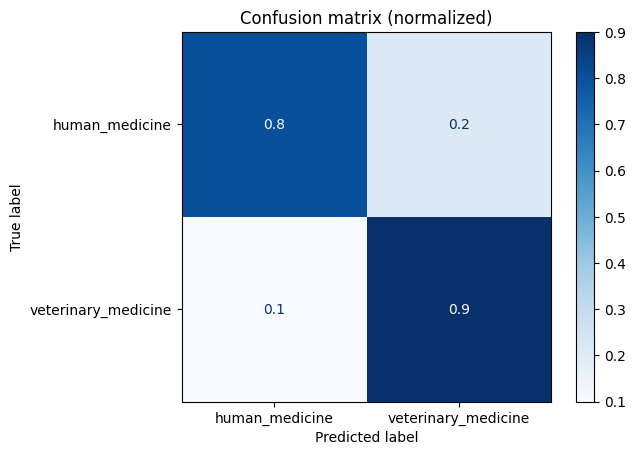

In [10]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from global_parameters import LABELS_MAP


labels = list(LABELS_MAP.keys())
test_classes = [labels[0] if label == 0 else labels[1] for label in test_y]
preds_classes = [labels[0] if label == 0 else labels[1] for label in pred_y]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=labels, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()